# Example use of the Sonic module Linckii.jl

See https://julialang.org, https://juliadb.org and https://juliastats.org for reference.

In [19]:
import Pkg                      # package manager
Pkg.activate("..")              # Project.toml
Pkg.instantiate()               # https://julialang.github.io/Pkg.jl/v1.0/index.html

Activating environment at `~/Documents/Calendar/Work/Noda/Code/Sonic.jl/Project.toml`


In [20]:
import Dates, JuliaDB, Random, StatsPlots

In [21]:
using StatsPlots
ENV["GKSwstype"] = "100"
gr(fmt = :png)

Plots.GRBackend()

Get secret token,

In [31]:
include("../src/LinckiiSecrets.jl")
secret = LinckiiSecrets.keab

(url = "https://canary.noda.se/~keab", key = "e86d93131e6bc12ae701d036e696cf8b")

Get access token,

In [87]:
include("../src/Linckii.jl")
access = Linckii.get_access(secret)

(url = "https://canary.noda.se/~keab", key = "e86d93131e6bc12ae701d036e696cf8b")

`GET https://canary.noda.se/~keab/api/v1/nodes`,

In [48]:
@time site_nodes = Linckii.get_nodes(access)

 19.236567 seconds (13.97 M allocations: 991.460 MiB, 1.59% gc time)


Table with 279 rows, 8 columns:
Columns:
#  colname           type
───────────────────────────────────
1  node_public       Bool
2  node_name         Symbol
3  device_id         Int64
4  node_id           Int64
5  node_owner        Bool
6  node_enabled      Bool
7  sensor_ids        Array{Int64,1}
8  node_description  String

`GET https://canary.noda.se/~keab/api/v1/devices`,

In [7]:
@time site_devices = Linckii.get_devices(access)

 37.619658 seconds (28.89 M allocations: 1.993 GiB, 1.61% gc time)


Table with 11 rows, 3 columns:
protocol_id  device_name                     device_id
──────────────────────────────────────────────────────
1            Symbol("Kelp-IQHeat")           1
2            :Scout                          2
1            Symbol("Kelp-Basic")            4
5            Symbol("Weather-Forecast")      6
6            Symbol("Grid-Basic")            7
6            Symbol("Grid-Controller")       8
7            Symbol("Heat-Load-Forecast")    9
2            :CMa1Xw                         10
2            Symbol("EcoGuard Sensor")       11
2            :WEPTech                        12
8            Symbol("Flexibility-Forecast")  13

`GET https://canary.noda.se/~keab/api/v1/sensors`,

In [8]:
@time site_sensors = Linckii.get_sensors(access)

 45.792620 seconds (37.75 M allocations: 2.596 GiB, 1.52% gc time)


Table with 175 rows, 5 columns:
Columns:
#  colname             type
────────────────────────────────
1  sensor_unit         FreeUnits
2  sensor_name         Symbol
3  protocol_id         Int64
4  sensor_id           Int64
5  sensor_description  String

In [49]:
site = (:nodes => site_nodes, :devices => site_devices, :sensors => site_sensors)
()

()

Save site,

In [50]:
@time Linckii.savesite(secret; site...)

  0.290983 seconds (553.28 k allocations: 27.989 MiB)


Load site,

In [51]:
@time site = Linckii.loadsite(secret, :nodes, :devices, :sensors)
()

  0.073725 seconds (71.19 k allocations: 3.692 MiB)


()

Specify patterns,

In [52]:
patterns = Dict(
    4 => Dict(
        :meter_effect           => identity,
        :meter_heatenergy       => identity,
        :meter_primreturntemp   => identity,
        :meter_primsupplytemp   => identity,
        :meter_volume           => identity,
        :meter_volumeflow       => identity,
        :outdoortemp            => identity,
        :outdoortemp_offset     => identity,
    ),
    6 => Dict(
        :cloudiness             => identity,
        :outdoortemp            => identity,
        :wind_direction         => identity,
        :wind_speed             => identity,
    ),
)

Dict{Int64,Dict{Symbol,typeof(identity)}} with 2 entries:
  4 => Dict(:meter_primreturntemp=>identity,:meter_effect=>identity,:outdoortem…
  6 => Dict(:cloudiness=>identity,:outdoortemp=>identity,:wind_direction=>ident…

Get pattern nodes,

In [78]:
rs = JuliaDB.rows(Linckii.get_pattern_nodes(patterns; site...))
if true
    rs = [(node_id = 62, device_id = 4), (node_id = 93, device_id = 4)] # [rs[Random.rand(1 : end)]]
end
rs

2-element Array{NamedTuple{(:node_id, :device_id),Tuple{Int64,Int64}},1}:
 (node_id = 62, device_id = 4)
 (node_id = 93, device_id = 4)

Save data,

In [55]:
dates = Dates.DateTime(2017, 12) : Dates.Month(1) : Dates.DateTime(2019, 12)

2017-12-01T00:00:00:1 month:2019-12-01T00:00:00

In [57]:
@time for r in rs
    for sensor_name in keys(patterns[r.device_id])
        filepath = "$(Linckii.datapath(secret, r.node_id, sensor_name)).db"
        try
            Linckii.savedata(access, r.node_id, sensor_name, dates...)
            println("$(filepath): Done")
        catch e
            println("$(filepath): $(e)")
        end
    end
end

db/linckii/~keab/data/62/meter_primreturntemp.db: Done
db/linckii/~keab/data/62/meter_effect.db: Done
db/linckii/~keab/data/62/outdoortemp.db: Done
db/linckii/~keab/data/62/meter_primsupplytemp.db: Done
db/linckii/~keab/data/62/meter_volumeflow.db: Done
db/linckii/~keab/data/62/meter_volume.db: Done
db/linckii/~keab/data/62/outdoortemp_offset.db: Done
db/linckii/~keab/data/62/meter_heatenergy.db: Done
305.579227 seconds (41.82 M allocations: 2.052 GiB, 0.20% gc time)


Random choice,

In [79]:
r = rs[Random.rand(1 : end)]

(node_id = 93, device_id = 4)

In [80]:
sensor_names = collect(keys(patterns[r.device_id]))

8-element Array{Symbol,1}:
 :meter_primreturntemp
 :meter_effect        
 :outdoortemp         
 :meter_primsupplytemp
 :meter_volumeflow    
 :meter_volume        
 :outdoortemp_offset  
 :meter_heatenergy    

In [81]:
sensor_name = sensor_names[Random.rand(1 : end)]

:meter_volume

Load data,

In [88]:
data = Linckii.loaddata(secret, r.node_id, sensor_name)

Table with 83642 rows, 3 columns:
datetime             variable       value
───────────────────────────────────────────
2018-02-14T12:58:06  :meter_volume  16948.1
2018-02-14T13:08:06  :meter_volume  16948.3
2018-02-14T13:18:06  :meter_volume  16948.4
2018-02-14T13:28:05  :meter_volume  16948.5
2018-02-14T13:38:06  :meter_volume  16948.7
2018-02-14T13:48:13  :meter_volume  16948.8
2018-02-14T13:58:06  :meter_volume  16949.0
2018-02-14T14:08:05  :meter_volume  16949.1
2018-02-14T14:18:14  :meter_volume  16949.2
2018-02-14T14:28:06  :meter_volume  16949.3
2018-02-14T14:38:06  :meter_volume  16949.5
2018-02-14T14:48:05  :meter_volume  16949.6
⋮
2019-11-30T22:15:11  :meter_volume  1711.68
2019-11-30T22:25:11  :meter_volume  1711.94
2019-11-30T22:35:10  :meter_volume  1712.19
2019-11-30T22:45:11  :meter_volume  1712.42
2019-11-30T22:55:11  :meter_volume  1712.67
2019-11-30T23:05:12  :meter_volume  1712.91
2019-11-30T23:15:11  :meter_volume  1713.15
2019-11-30T23:25:11  :meter_volume  1713.3

Simple graphics,

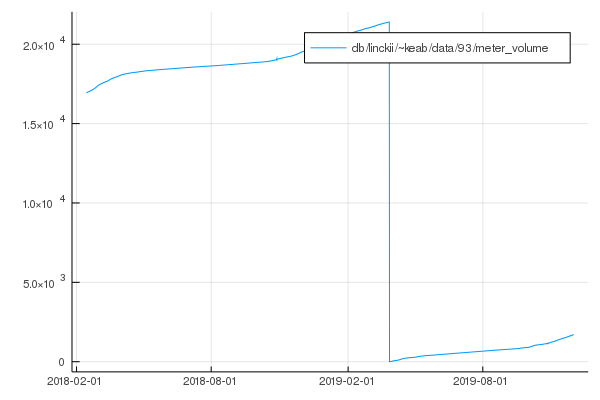

In [84]:
@df data plot(:datetime, :value, label = Linckii.datapath(secret, r.node_id, r_sensor_name))